In [1]:
import numpy as np
import pandas as pd

# 数据处理

In [2]:
data = pd.read_csv('./dataset/Tweets.csv')

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data = data[['airline_sentiment', 'text']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [6]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

树算法对处理不均匀数据效果较好

In [8]:
import re # 正则表达式

In [9]:
token = re.compile(r'[A-Za-z]+|[!?.:,()]')

In [10]:
def extract_text(text):
    new_text = token.findall(text)
    new_text = ' '.join([x.lower() for x in new_text]) # 变为小写，注意join前要有空格，否则会拼成一个单词
    return new_text

In [11]:
x = data.text.apply(extract_text)

In [12]:
y = data.airline_sentiment

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [15]:
x_train.shape, x_test.shape

((10980,), (3660,))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vect = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=3)
# (ngram_range=(1,3) 1-3个单词作为一个序列

In [18]:
x_train_vect = vect.fit_transform(x_train)  # 文本向量化

In [19]:
x_train_vect # 10980x361

<10980x7698 sparse matrix of type '<class 'numpy.float64'>'
	with 116278 stored elements in Compressed Sparse Row format>

In [20]:
x_test_vect = vect.transform(x_test)

# 模型构建

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
model = RandomForestClassifier()

In [23]:
model.fit(x_train_vect, y_train)

RandomForestClassifier()

In [24]:
model.score(x_train_vect, y_train)

0.9934426229508196

In [25]:
model.score(x_test_vect, y_test)

0.753551912568306

In [27]:
model2 = RandomForestClassifier(n_estimators=500)

In [28]:
model2.fit(x_train_vect, y_train)

RandomForestClassifier(n_estimators=500)

In [29]:
model2.score(x_train_vect, y_train)

0.9934426229508196

In [30]:
model2.score(x_test_vect, y_test)

0.7543715846994535

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param = {
    'max_depth': range(1,500,10),
    'criterion': ['gini', 'entropy']
}

In [33]:
grid_s = GridSearchCV(RandomForestClassifier(n_jobs=8),
                      param_grid=param,
                      cv=5)

In [34]:
x_vect = vect.transform(x)

In [35]:
grid_s.fit(x_vect, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=8),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 500, 10)})

In [36]:
x_vect

<14640x7698 sparse matrix of type '<class 'numpy.float64'>'
	with 152642 stored elements in Compressed Sparse Row format>

In [37]:
grid_s.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=371, n_jobs=8)

In [38]:
grid_s.best_score_

0.6948087431693989

# 朴素贝叶斯

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
model = MultinomialNB(alpha=0.0001)

In [41]:
model.fit(x_train_vect, y_train)

MultinomialNB(alpha=0.0001)

In [42]:
model.score(x_train_vect, y_train)

0.8883424408014572

In [43]:
model.score(x_test_vect, y_test)

0.7502732240437159

In [44]:
test_score = []
alpha = np.linspace(0.00001, 0.01, 100)  # 等距
for a in alpha:
    model = MultinomialNB(alpha=a)
    model.fit(x_train_vect, y_train)
    test_score.append(model.score(x_test_vect, y_test))

In [45]:
max_score = max(test_score)
max_score

0.7573770491803279

In [46]:
index = test_score.index(max_score)

In [47]:
index

94

In [48]:
alpha[index]

0.009495454545454547

In [49]:
best_alpha = alpha[index]

# 模型评价

## F1-Score

使用classification_report函数来查看针对每个类别的预测准确性

In [50]:
from sklearn.metrics import classification_report

In [51]:
model = MultinomialNB(alpha=best_alpha)
model.fit(x_train_vect, y_train)

MultinomialNB(alpha=0.009495454545454547)

In [52]:
pred = model.predict(x_test_vect)

In [53]:
import pprint  # 打印
pprint.pprint(classification_report(y_test, pred))

('              precision    recall  f1-score   support\n'
 '\n'
 '    negative       0.78      0.94      0.85      2288\n'
 '     neutral       0.63      0.38      0.47       781\n'
 '    positive       0.77      0.54      0.63       591\n'
 '\n'
 '    accuracy                           0.76      3660\n'
 '   macro avg       0.73      0.62      0.65      3660\n'
 'weighted avg       0.74      0.76      0.74      3660\n')


## 混淆矩阵

In [54]:
from sklearn.metrics import confusion_matrix

In [55]:
cm = confusion_matrix(y_test, pred)

In [56]:
cm

array([[2158,   99,   31],
       [ 422,  297,   62],
       [ 198,   76,  317]], dtype=int64)

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

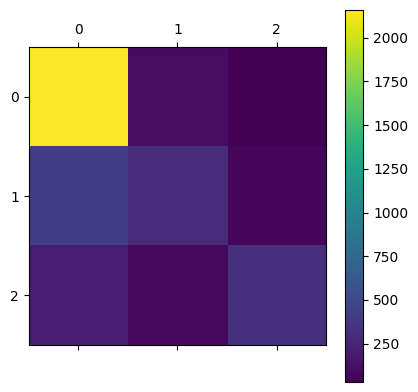

In [58]:
plt.matshow(cm)
plt.colorbar()